In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import os
import matplotlib.pyplot as plt

import rpy2
# from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [ ]:
info = pd.read_csv('D:/braindata/AMP-AD_MSBB_MSSM_covariates_mRNA_AffymetrixU133AB.tsv', sep='\t')
info

In [ ]:
stage = info.groupby(by='CDR').count().reset_index()
stage['stage'] = ('CDR' + stage['CDR'].astype(str))
stage

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(stage['stage'], stage['BrainBank'], width=0.3, color='tan')  # , color='tan'
for i in range(len(stage)):
    plt.text(stage['stage'][i], stage['BrainBank'][i] + 0.1, stage['BrainBank'][i], ha='center', va='bottom')
plt.ylim((0, 25))
plt.ylabel('Number of Individuals')

ax = plt.gca()  # Get the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis.grid(color='lightgray', linewidth=0.5, alpha=0.8)


In [ ]:
micepath = 'D:/'
micefiles = os.listdir('D:')

AllFC = pd.DataFrame()


In [ ]:
CDR10 = []
CDR20 = []
CDR21 = []

up_gene10 = []
down_gene10 = []
up_gene20 = []
down_gene20 = []

CDRAll = set()
gene_num = []
patients = []

dif_gene = pd.DataFrame()
dif_gene['Num'] = range(1, 20)
dif_gene['Region'] = 'Region' + dif_gene['Num'].astype(str)

# Record the number of differential genes in each region (excluding duplicates in the three-stage comparison)
dif_gene['dif_gene_num'] = np.nan

# Record the number of differential genes in the three-stage comparison
dif_gene['CDR1VSCDR0'] = np.nan
dif_gene['CDR2VSCDR0'] = np.nan
dif_gene['CDR2VSCDR1'] = np.nan

# Record the number of upregulated genes and downregulated genes in each region (Mid-stage VS Early stage 10, Late-stage VS Early stage 20)
dif_gene['up_gene10'] = np.nan
dif_gene['down_gene10'] = np.nan
dif_gene['up_gene20'] = np.nan
dif_gene['down_gene20'] = np.nan


In [ ]:
CDRframe = pd.read_csv(micepath+micefiles[0])
CDRframe.dropna(inplace=True)
conmon_gene = CDRframe['genename'].to_list()
len(conmon_gene)

In [ ]:
for i in range(len(micefiles)):
    data = pd.read_csv(micepath+micefiles[i])
    data.dropna(inplace=True)
    genename = data['genename'].to_list()

    conmon_gene = [i for i in conmon_gene if i in genename]
len(conmon_gene)
# pd.DataFrame(conmon_gene,columns=['genename']).to_csv('conmon_gene_18431.csv',index=False)

In [ ]:
CDR10 = []
CDR20 = []
CDR21 = []

up_gene10 = []
down_gene10 = []
up_gene20 = []
down_gene20 = []

CDRAll = set()
gene_num = []
patients = []

dif_gene = pd.DataFrame()
dif_gene['Num'] = range(1, len(micefiles) + 1)
dif_gene['Region'] = 'Region' + dif_gene['Num'].astype(str)

# Record the number of times each patient appears
for i in range(len(micefiles)):
    data = pd.read_csv(micepath + micefiles[i])
    data = data[data['genename'].isin(conmon_gene)]

    patients += data.columns[2:].tolist()

    # Match the CDR values in the 'info' dataframe with the 'class' values in 'fenzu'
    fenzu = info.copy()
    fenzu['BrainBank'] = fenzu['BrainBank'].astype(str).apply(lambda x: "X" + x)
    fenzu = fenzu[fenzu['BrainBank'].isin(data.columns[2:])].reset_index(drop=True)
    fenzu['CDR'] = fenzu['CDR'].apply(lambda x: 'CDR0' if x < 1 else ('CDR1' if x <= 2 else 'CDR2'))
    fenzu = fenzu.loc[:, ['BrainBank', 'CDR']]
    fenzu = fenzu.rename(columns={'BrainBank': 'list', 'CDR': 'class'})

    # One-hot encode the 'class' values in 'fenzu'
    design = pd.get_dummies(fenzu['class'])
    design.index = fenzu['list'].tolist()

    data.dropna(inplace=True)

    # Save the column names (gene names)
    lieming1 = data['genename'].tolist()
    # Remove the first two columns, leaving only the gene features
    data = data.iloc[:, 2:]
    # Set the row index of 'data' to be the gene names
    data.index = lieming1

    # CDR1-CDR0
    # Prepare data for limma differential analysis
    # Create a contrast matrix using the 'limma' package in R
    limma = importr("limma")
    contrast_matrix = limma.makeContrasts("CDR1-CDR0", levels=design)

    # Start the analysis - step 1
    fit = limma.lmFit(data, design)
    # Step 2
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    # Step 3
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
    # Remove rows with missing values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    # Use criteria: |logFC| > 0.585 and padj < 0.05 (adjusted P-value)
    foldChange = 0.585
    padj = 0.05
    # Filter for all differential genes based on the criteria
    All_diffSig = diffsig.loc[(diffsig['P.Value'] < padj) & (
        (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

    # Upregulated genes
    diffup = All_diffSig.loc[(All_diffSig['P.Value'] < padj)
                            & (All_diffSig['logFC'] > foldChange)]

    # Downregulated genes
    diffdown = All_diffSig.loc[(All_diffSig['P.Value'] < padj) & (
        All_diffSig['logFC'] < -foldChange)]

    CDR10.append(len(All_diffSig))
    CDR1CDR0 = All_diffSig.index.tolist()

    up_gene10.append(len(diffup))
    down_gene10.append(len(diffdown))

    # CDR2-CDR0
    # Prepare data for limma differential analysis
    # Create a contrast matrix using the 'limma' package in R
    limma = importr("limma")
    contrast_matrix = limma.makeContrasts("CDR2-CDR0", levels=design)

    # Start the analysis - step 1
    fit = limma.lmFit(data, design)
    # Step 2
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    # Step 3
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
    # Remove rows with missing values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    # Use criteria: |logFC| > 0.585 and padj < 0.05 (adjusted P-value)
    foldChange = 0.585
    padj = 0.05
    # Filter for all differential genes based on the criteria
    All_diffSig = diffsig.loc[(diffsig['P.Value'] < padj) & (
        (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

    # Upregulated genes
    diffup = All_diffSig.loc[(All_diffSig['P.Value'] < padj)
                            & (All_diffSig['logFC'] > foldChange)]

    # Downregulated genes
    diffdown = All_diffSig.loc[(All_diffSig['P.Value'] < padj) & (
        All_diffSig['logFC'] < -foldChange)]

    CDR20.append(len(All_diffSig))
    CDR2CDR0 = All_diffSig.index.tolist()

    up_gene20.append(len(diffup))
    down_gene20.append(len(diffdown))

    # CDR2-CDR1
    # Prepare data for limma differential analysis
    # Create a contrast matrix using the 'limma' package in R
    limma = importr("limma")
    contrast_matrix = limma.makeContrasts("CDR2-CDR1", levels=design)

    # Start the analysis - step 1
    fit = limma.lmFit(data, design)
    # Step 2
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    # Step 3
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
    # Remove rows with missing values
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()

    # Use criteria: |logFC| > 0.585 and padj < 0.05 (adjusted P-value)
    foldChange = 0.585
    padj = 0.05
    # Filter for all differential genes based on the criteria
    All_diffSig = diffsig.loc[(diffsig['P.Value'] < padj) & (
        (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

    # Upregulated genes
    diffup = All_diffSig.loc[(All_diffSig['P.Value'] < padj)
                            & (All_diffSig['logFC'] > foldChange)]

    # Downregulated genes
    diffdown = All_diffSig.loc[(All_diffSig['P.Value'] < padj) & (
        All_diffSig['logFC'] < -foldChange)]

    CDR21.append(len(All_diffSig))
    CDR2CDR1 = All_diffSig.index.tolist()

    # Find the union of differential genes
    dif_gene_ = set(CDR1CDR0).union(CDR2CDR0, CDR2CDR1)
    gene_num.append(len(dif_gene_))
    CDRAll = CDRAll | dif_gene_  #1014


In [ ]:
gene_num
len(CDRAll)

In [ ]:
dif_gene['dif_gene_num'] = gene_num
dif_gene['CDR1VSCDR0'] =CDR10
dif_gene['CDR2VSCDR0'] =CDR20
dif_gene['CDR2VSCDR1'] =CDR21

dif_gene['up_gene10'] = up_gene10
dif_gene['down_gene10'] = down_gene10
dif_gene['up_gene20'] = up_gene20
dif_gene['down_gene20'] = down_gene20
dif_gene


In [ ]:
# Plot for dif_gene_num
plt.figure(figsize=(10, 6))
plt.bar(dif_gene['Region'], dif_gene['dif_gene_num'], width=0.3, color='tan') # , color='tan'
for i in range(len(dif_gene)):
    plt.text(dif_gene['Region'][i], dif_gene['dif_gene_num'][i]+2, dif_gene['dif_gene_num'][i], ha='center', va='bottom')
# plt.ylim((0, 25))
plt.ylabel('Number of Differential Genes')
plt.xticks(rotation=45)

ax = plt.gca()  # Get the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis.grid(color='lightgray',linewidth=0.5,alpha=0.8)


In [ ]:
up_down_gene = pd.DataFrame({'Mid-term Group': [dif_gene['up_gene10'].sum(), dif_gene['down_gene10'].sum()], 
              'Late-term Group': [dif_gene['up_gene20'].sum(),dif_gene['down_gene20'].sum()]}, index=['Upregulated Genes','Downregulated Genes'])
up_down_gene


In [ ]:
x = np.arange(2)
width = 0.3
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, up_down_gene['Mid-term Group'], width, label='Mid-term Group', color='tan')
rects2 = ax.bar(x + width/2, up_down_gene['Late-term Group'], width, label='Late-term Group', color='steelblue')
ax.set_ylabel('Significant Genes Count (Count)')
ax.set_xticks(x)
ax.set_xticklabels(['Upregulated Genes', 'Downregulated Genes'])
ax.legend()

# Adding numbers as text labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Vertical text offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


In [ ]:
# Creating an empty list to store the names of differentially expressed genes
genenames = []

# Iterating through the set CDRAll, which contains the union of differentially expressed genes
for g_name in CDRAll:
    genenames.append(g_name)

# Sorting the gene names in alphabetical order
genenames = sorted(genenames)

# Determining the total number of unique genes in the list
total_unique_genes = len(genenames)


In [ ]:
# pd.DataFrame(genenames,columns=['genename']).to_csv('genenames_1014.csv',index=False)

19 Region

In [ ]:
CDRframe = CDRframe[CDRframe['genename'].isin(conmon_gene)]
CDRframe['genenum'] = 1

for i in range(1,19):
    data = pd.read_csv(micepath+micefiles[i])
    data = data[data['genename'].isin(conmon_gene)]
    data['genenum'] = i+1

    CDRframe = pd.concat([CDRframe, data], join='outer', ignore_index=True)

CDRframe.sort_values(by=['genename','genenum'], inplace=True)
CDRframe.reset_index(drop=True,inplace=True)
CDRframe

In [ ]:
# CDRframe.to_csv('CDRframe.csv',index=False)

In [ ]:
# Counting the occurrences of each patient's data in the 'patients' list
patient_counts = pd.value_counts(patients)

# Creating a DataFrame to store the patient and their corresponding data occurrence counts
patients_times = pd.DataFrame(patient_counts)

# Resetting the index of the DataFrame to have a 'patient' column
patients_times.reset_index(inplace=True)

# Renaming the columns of the DataFrame to 'patient' and 'times'
patients_times.columns = ['patient', 'times']


In [ ]:
# Filtering patients with data from at least 3 brain regions
patient3 = patients_times[patients_times['times'] >= 3]['patient'].to_list()

# Sorting the patient identifiers
patient3 = sorted(patient3)

# Getting the count of such patients
num_patient3 = len(patient3)

In [ ]:
patient3.insert(0,'genename')
patient3.insert(1,'genenum')

In [ ]:
# pd.DataFrame(patient3,columns=['patient']).to_csv('patient3.csv',index=False)

FC

In [ ]:
CDR10_FC = pd.DataFrame()
CDR20_FC = pd.DataFrame()
CDR21_FC = pd.DataFrame()

for m in range(len(micefiles)):
    # Read data from a CSV file
    data = pd.read_csv(micepath + micefiles[m])
    # Filter data based on common genes
    data = data[data['genename'].isin(common_gene)]

    # Extract the list of patients
    patient_list = data.columns[2:]

    # Map CDR values from 'info' to 'fenzu' class
    fenzu = info.copy()
    fenzu['BrainBank'] = fenzu['BrainBank'].astype(str).apply(lambda x: "X" + x)
    fenzu = fenzu[fenzu['BrainBank'].isin(patient_list)].reset_index(drop=True)
    fenzu['CDR'] = fenzu['CDR'].apply(lambda x: 'CDR0' if x < 1 else ('CDR1' if x <= 2 else 'CDR2'))
    fenzu = fenzu.loc[:, ['BrainBank', 'CDR']]
    fenzu = fenzu.rename(columns={'BrainBank': 'list', 'CDR': 'class'})

    # Encode the 'class' column as one-hot vectors
    design = pd.get_dummies(fenzu['class'])
    design.index = fenzu['list'].tolist()

    # Drop rows with missing values in the data
    data.dropna(inplace=True)

    # Store the gene names in 'lieming1'
    lieming1 = data['genename'].tolist()
    
    # Remove the first two columns (gene identifier and description)
    data = data.iloc[:, 2:]

    # Set the row index of 'data' to 'genename'
    data.index = lieming1

    # CDR1-CDR0
    limma = importr("limma")
    contrast_matrix = limma.makeContrasts("CDR1-CDR0", levels=design)
    fit = limma.lmFit(data, design)
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()
    diffsig.reset_index(inplace=True)
    diffsig['Region'] = m + 1
    CDR10_temp = diffsig[diffsig['index'].isin(genenames)]
    CDR10_FC = pd.concat([CDR10_FC, CDR10_temp], join='outer', ignore_index=True)

    # CDR2-CDR0
    contrast_matrix = limma.makeContrasts("CDR2-CDR0", levels=design)
    fit = limma.lmFit(data, design)
    fit2 = limma.contrasts_fit(fit, contrast_matrix)
    fit2 = limma.eBayes(fit2)
    tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
    nrDEG = tempOutput.dropna()
    diffsig = nrDEG.copy()
    diffsig.reset_index(inplace=True)
    diffsig['Region'] = m + 1
    CDR20_temp = diffsig[diffsig['index'].isin(genenames)]
    CDR20_FC = pd.concat([CDR20_FC, CDR20_temp], join='outer', ignore_index=True)


In [ ]:
fenzu

In [ ]:
CDR10_FC

In [ ]:
CDR20_FC

In [ ]:
CDR10_FC.sort_values(by=['index','Region'], inplace=True)
CDR20_FC.sort_values(by=['index','Region'], inplace=True)
CDR20_FC

In [ ]:
CDR10_FC['index'].to_list() == CDR20_FC['index'].to_list()

In [ ]:
FC = pd.DataFrame({"CDR1FC": CDR10_FC['logFC'].to_list()
                  ,"CDR2FC": CDR20_FC['logFC'].to_list() 
                })
FC

In [ ]:
positive10  = np.where(FC['CDR1FC'] > 0)[0].tolist()
positive20  = np.where(FC['CDR2FC'] > 0)[0].tolist()
CDR10_FC['index'].to_list() == CDR20_FC['index'].to_list()

In [ ]:
# Replace negative values with their absolute values
FC[FC < 0] = -FC
# Add a 'genename' column from CDR10_FC's 'index' values
FC['genename'] = CDR10_FC['index'].to_list()
# Select specific columns 'genename', 'CDR1FC', and 'CDR2FC'
FC = FC[['genename', 'CDR1FC', 'CDR2FC']]


In [ ]:
# Set the weights of non-significant genes in 'CDR1FC' to 0
FC.loc[FC['CDR1FC'] < 0.585, 'CDR1FC'] = 0
# Add a small value to prevent all-zero genes
FC['CDR1FC'] += 0.000001

# Set the weights of non-significant genes in 'CDR2FC' to 0
FC.loc[FC['CDR2FC'] < 0.585, 'CDR2FC'] = 0
# Add a small value to prevent all-zero genes
FC['CDR2FC'] += 0.000001


In [ ]:
FC['CDR1FC'].sum() , FC['CDR2FC'].sum()

In [ ]:
FC

In [ ]:
# Filter CDRframe to include only patients with data in at least 3 brain regions
CDRframe = CDRframe.loc[:, patient3]


In [ ]:
CDRframe = CDRframe[CDRframe['genename'].isin(genenames)]
CDRframe.shape, CDRframe.isna().sum().sum()

In [ ]:
for gen in genenames:
    # Filter the data for the current gene
    genedata = CDRframe.loc[CDRframe['genename'] == gen, :]

    # Calculate the centering for each column (subtract minimum value)
    center = genedata.iloc[:, 2:].apply(lambda x: x - np.nanmin(x), axis=0)
    
    # Calculate the range (maximum - minimum) for each column
    R = np.nanmax(genedata.iloc[:, 2:], axis=0) - np.nanmin(genedata.iloc[:, 2:], axis=0)
    
    # Normalize the centered data by dividing by the range (scaling)
    x_star = center / R[np.newaxis, :]

    # Further normalize the data by multiplying by 3 and adding 1
    genedata.iloc[:, 2:] = x_star * 3 + 1

    # Update the normalized data in the original DataFrame
    CDRframe.loc[CDRframe['genename'] == gen, CDRframe.columns[2:]] = genedata.iloc[:, 2:]

# Reset the index of the DataFrame
CDRframe.reset_index(drop=True, inplace=True)


In [ ]:
CDRframe.iloc[:,2:].sum().sum()

In [ ]:
list = CDRframe.columns[2:]
group = info.copy()
group['BrainBank'] = group['BrainBank'].astype(str).apply(lambda x: "X" + x)
group = group[group['BrainBank'].isin(list)].reset_index(drop=True)
group['CDR'] = group['CDR'].apply(lambda x: 'CDR0' if x < 1 else ('CDR1' if x <= 2 else 'CDR2'))
group = group.loc[:,['BrainBank','CDR']]
group


In [ ]:
BrainBank = group['BrainBank'].to_list()

# Create a weighted data table
FChou = pd.DataFrame(index=genenames, columns=BrainBank)
FChou


In [ ]:
for gen in FChou.index:
    for m in FChou.columns:
        brain_data = CDRframe.loc[CDRframe['genename'] == gen, m]
        degree = group[group['BrainBank'] == m]['CDR'].tolist()[0]

        if degree == "CDR0":
            non_nan_series = brain_data.dropna()
            FChou.loc[gen, m] = np.mean(non_nan_series)

        elif degree == "CDR1":
            weights = FC.loc[FC['genename'] == gen, "CDR1FC"]
            weights = weights[(-brain_data.isna()).to_list()]
            brain_data = brain_data.dropna()
            FChou.loc[gen, m] = np.dot(weights / np.sum(weights), brain_data)

        else:
            weights = FC.loc[FC['genename'] == gen, "CDR2FC"]
            weights = weights[(-brain_data.isna()).to_list()]
            brain_data = brain_data.dropna()
            FChou.loc[gen, m] = np.dot(weights / np.sum(weights), brain_data)


In [ ]:
FChou.sum().sum()

In [ ]:
FChou = FChou.astype(float)
FChou

In [ ]:
# Convert 'CDR' column to one-hot encoding
design = pd.get_dummies(group['CDR'])
design.index = group['BrainBank'].tolist()


In [ ]:
# CDR1-CDR0  
# Differential analysis using limma  Data preparation
# Create a contrast matrix using the limma package in R
limma = importr("limma")
contrast_matrix = limma.makeContrasts("CDR1-CDR0", levels=design)

# Start the analysis - Step 1
fit = limma.lmFit(FChou, design)
# Step 2
fit2 = limma.contrasts_fit(fit, contrast_matrix)
fit2 = limma.eBayes(fit2)
# Step 3
tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
# Remove rows with missing values
nrDEG = tempOutput.dropna()
diffsig = nrDEG.copy()

# We use |logFC| > 0.585 and padj < 0.05 (adjusted P-value) as thresholds
foldChange = 0.585
padj = 0.05

# Filter out all differentially expressed genes
All_diffSig10 = diffsig.loc[(diffsig['P.Value'] < padj) & (
    (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

# Upregulated
diffup10 = All_diffSig10.loc[(All_diffSig10['P.Value'] < padj)
                        & (All_diffSig10['logFC'] > foldChange)]

# Downregulated
diffdown10 = All_diffSig10.loc[(All_diffSig10['P.Value'] < padj) & (
    All_diffSig10['logFC'] < -foldChange)]


In [ ]:
# CDR2-CDR0  
# Differential analysis using limma  Data preparation
# Create a contrast matrix using the limma package in R
limma = importr("limma")
contrast_matrix = limma.makeContrasts("CDR2-CDR0", levels=design)

# Start the analysis - Step 1
fit = limma.lmFit(FChou, design)
# Step 2
fit2 = limma.contrasts_fit(fit, contrast_matrix)
fit2 = limma.eBayes(fit2)
# Step 3
tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
# Remove rows with missing values
nrDEG = tempOutput.dropna()
diffsig = nrDEG.copy()

# We use |logFC| > 0.585 and padj < 0.05 (adjusted P-value) as thresholds
foldChange = 0.585
padj = 0.05

# Filter out all differentially expressed genes
All_diffSig20 = diffsig.loc[(diffsig['P.Value'] < padj) & (
    (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

# Upregulated
diffup20 = All_diffSig20.loc[(All_diffSig20['P.Value'] < padj)
                        & (All_diffSig20['logFC'] > foldChange)]

# Downregulated
diffdown20 = All_diffSig20.loc[(All_diffSig20['P.Value'] < padj) & (
    All_diffSig20['logFC'] < -foldChange)]


In [ ]:
# CDR2-CDR1 
# Differential analysis using limma  Data preparation
# Create a contrast matrix using the limma package in R
limma = importr("limma")
contrast_matrix = limma.makeContrasts("CDR2-CDR1", levels=design)

# Start the analysis - Step 1
fit = limma.lmFit(FChou, design)
# Step 2
fit2 = limma.contrasts_fit(fit, contrast_matrix)
fit2 = limma.eBayes(fit2)
# Step 3
tempOutput = limma.topTable(fit2, adjust="fdr", n=float("inf"))
# Remove rows with missing values
nrDEG = tempOutput.dropna()
diffsig = nrDEG.copy()

# We use |logFC| > 0.585 and padj < 0.05 (adjusted P-value) as thresholds
foldChange = 0.585
padj = 0.05

# Filter out all differentially expressed genes
All_diffSig21 = diffsig.loc[(diffsig['P.Value'] < padj) & (
    (diffsig['logFC'] > foldChange) | (diffsig['logFC'] < -foldChange))]

# Upregulated
diffup21 = All_diffSig21.loc[(All_diffSig21['P.Value'] < padj)
                        & (All_diffSig21['logFC'] > foldChange)]

# Downregulated
diffdown21 = All_diffSig21.loc[(All_diffSig21['P.Value'] < padj) & (
    All_diffSig21['logFC'] < -foldChange)]


In [ ]:
limma_all = [len(All_diffSig10), len(All_diffSig20), len(All_diffSig21)]
limma_up = [len(diffup10), len(diffup20), len(diffup21)]
limma_down = [len(diffdown10), len(diffdown20), len(diffdown21)]

limma_diff = pd.DataFrame(index=['CDR1-CDR0', 'CDR2-CDR0', 'CDR2-CDR1'])
limma_diff['All Differential Genes'] = limma_all
limma_diff['Upregulated Genes'] = limma_up
limma_diff['Downregulated Genes'] = limma_down
limma_diff


In [ ]:
limma_all_gene = set(All_diffSig10.index.to_list()).union(All_diffSig20.index.to_list(), All_diffSig21.index.to_list())
len(limma_all_gene)

In [ ]:
limma_data = FChou.loc[limma_all_gene,:]
limma_data.sort_index(inplace=True)
limma_data

In [ ]:
limma_data.sum().sum()

Curve

In [ ]:
kenerl_curve = limma_data.copy()
kenerl_curve.columns = group['CDR']
kenerl_curve

In [ ]:
CDR0 = []
CDR1 = []
CDR2 = []
for i in range(len(group)):
    if group['CDR'][i] == 'CDR0':
        CDR0 = CDR0 + kenerl_curve.iloc[:,i].to_list()
    elif group['CDR'][i] == 'CDR1':
        CDR1 = CDR1 + kenerl_curve.iloc[:,i].to_list()
    else:
        CDR2 = CDR2 + kenerl_curve.iloc[:,i].to_list()

In [ ]:
import seaborn as sns
sns.kdeplot(CDR0, shade=True)
sns.kdeplot(CDR1, shade=True)
sns.kdeplot(CDR2, shade=True)
plt.legend(['Early', 'Intermediate', 'Late'])


Initialisation Configuration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
from sklearn.cluster import KMeans

pandas2ri.activate()

plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Standardisation of data

In [3]:
from sklearn. preprocessing import StandardScaler

scaler = StandardScaler()
scaled_limma = pd.DataFrame(scaler.fit_transform(limma_data), columns= limma_data.columns , index = limma_data.index)

scaled_limma

,X1006,X1012,X1018,X1023,X1027,X1039,X111,X13,X176,X184,...,X941,X956,X963,X972,X973,X975,X988,X989,X990,X992
AACS,0.040145,0.380907,-0.546453,0.485592,-1.283999,1.947714,-0.712846,-0.399685,-0.853669,0.558296,...,1.164374,0.132191,0.332997,1.621314,0.740598,-1.278277,0.632864,-0.411796,-0.084379,-1.017602
ABCA8,0.850539,1.103616,-1.602605,0.672544,-0.397754,1.149659,1.140159,-0.199300,1.226691,2.136472,...,0.738354,1.035865,-0.951173,1.379345,0.066544,0.072512,1.393987,-1.055761,0.619896,0.200372
ABCG2,-0.192338,0.154886,0.106349,0.200662,2.491124,-0.967348,0.769059,-0.170581,-0.820731,0.300132,...,0.404714,-0.467576,0.668990,-0.630775,1.587003,0.495478,1.846550,2.301961,-1.119864,1.077416
AEBP1,-0.348931,-1.224473,-0.256958,-1.197296,0.570535,-1.604989,-1.151035,-0.248175,-0.154275,-0.482999,...,-3.063257,-0.685881,-0.266475,-0.964559,1.824401,0.719773,1.918543,0.659002,-1.388280,1.252222
AKR1C3,-0.425908,-2.031274,-0.036859,-1.326577,0.408186,-1.660805,-1.229664,0.244895,-0.107514,0.241079,...,-2.165864,-0.711486,-0.042643,-1.485030,1.824418,1.010818,1.918558,0.768676,-1.767086,1.157654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WASF1,-1.056959,-0.986973,0.870707,-0.623385,-1.284005,-1.111480,-1.455078,0.605962,-0.807262,0.139537,...,0.883812,-0.530618,-0.578067,-0.608986,-0.959932,-1.278281,-0.489679,-1.055771,-1.188841,0.417101
WBSCR17,-1.056959,0.524670,-0.070059,0.287772,-0.184885,1.249278,0.159050,0.110120,0.536598,-0.314603,...,-0.747600,-0.339991,0.032358,0.369076,-0.254217,1.516298,-0.433239,-0.860817,-0.536976,-1.017604
XK,0.077672,-0.555972,0.150693,-0.883953,0.866965,-0.640794,-0.422113,-0.601048,-1.458618,0.373474,...,-1.149465,-0.613145,-0.003535,-0.722564,1.414694,0.083837,0.483782,0.915708,-0.090127,1.084210
ZNF804A,0.128000,-1.244650,-0.901279,-0.410168,0.272540,-1.067529,-0.814628,-0.626414,0.337216,-0.293214,...,-0.240517,-0.299439,0.297433,-1.614302,1.824403,1.391104,1.129406,0.885882,-1.116914,0.689314


Downgraded to 5 dimensions using UMAP (downgraded for number of samples, not for number of genes)

In [4]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=5, n_epochs=500,random_state=42,
                    metric='euclidean', n_neighbors=30, min_dist=0.1)
reduced_data = reducer.fit_transform(scaled_limma)
reduced_data

array([[14.777975 , 11.254902 ,  7.3953953,  6.534886 ,  3.9179041],
       [14.794454 , 11.398916 ,  7.4124284,  6.6952305,  3.5617964],
       [ 9.219906 ,  7.9057903,  4.5280366,  8.020296 ,  4.7665143],
       [ 9.069172 ,  7.8283052,  4.5575037,  7.9925714,  5.1518583],
       [ 8.643444 ,  8.231381 ,  4.385399 ,  8.019133 ,  5.1332884],
       [ 9.075234 ,  8.042442 ,  4.1918974,  8.094989 ,  4.7523265],
       [14.298121 ,  8.8085   ,  6.9558153,  6.6686587,  2.1179469],
       [14.545201 , 11.35265  ,  7.5268106,  6.7112517,  3.2406154],
       [ 9.252877 ,  7.901635 ,  3.3514392,  8.401932 ,  3.8520482],
       [13.902064 ,  8.49716  ,  6.466996 ,  6.818977 ,  2.63447  ],
       [14.19953  ,  8.755067 ,  7.075308 ,  6.670009 ,  2.218064 ],
       [14.829521 ,  8.960823 ,  6.697759 ,  6.814691 ,  2.5891933],
       [14.639787 ,  9.838005 ,  6.7737136,  6.9964695,  3.2613535],
       [14.469316 ,  9.0865755,  6.598658 ,  6.345713 ,  2.503977 ],
       [14.417959 , 10.951355 ,  7

Exploring the optimal number of clusters

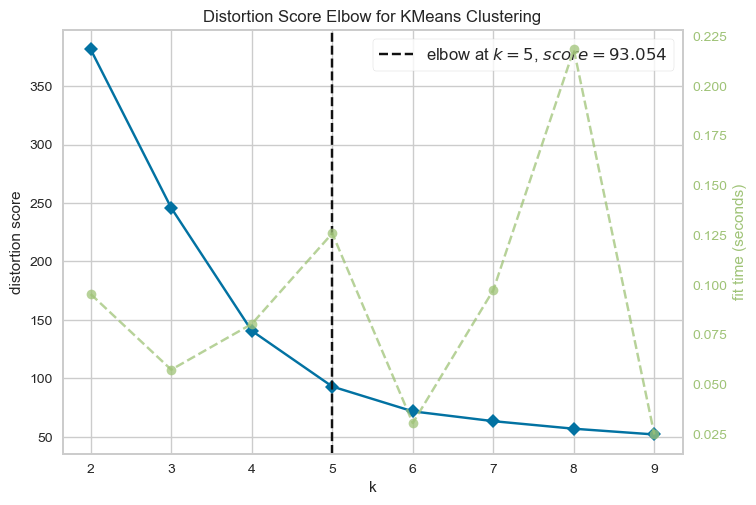

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,10), timings=True)
visualizer.fit(reduced_data)
visualizer.show()

Clustering of dimensionality reduced data using kmeans

In [6]:
kmeans = KMeans(n_clusters=5, random_state=42)  # Specify the number of clusters
clusters = kmeans.fit(reduced_data)
# clusters.labels_

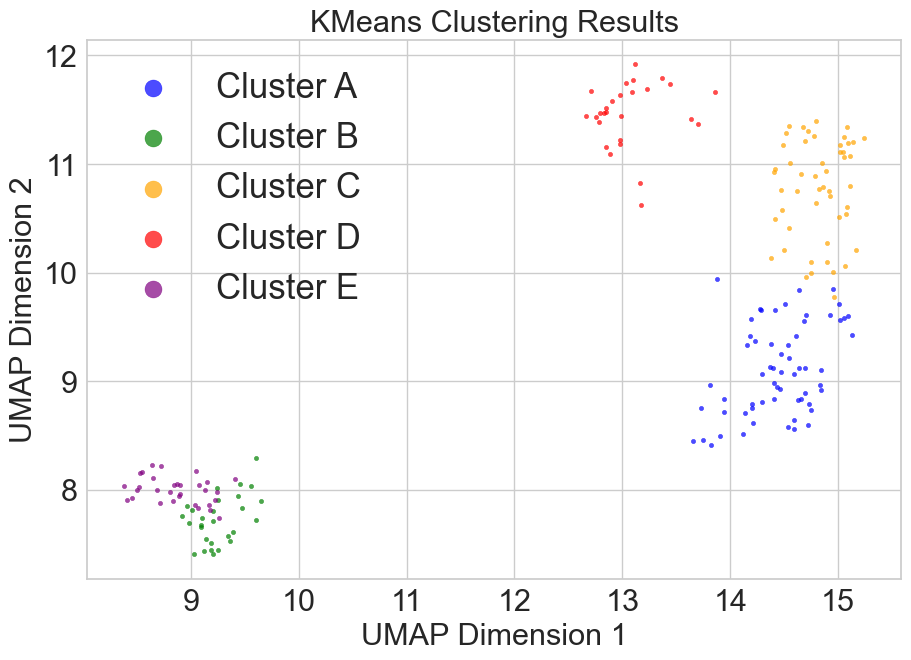

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming reduced_data is UMAP-embedded data and clusters.labels_ contains cluster assignments

# Create a figure for the scatter plot
plt.figure(figsize=(10.5, 7))

# Get unique cluster labels
unique_labels = np.unique(clusters.labels_)

# Define a mapping of cluster labels
category_colors = {
    "Cluster A": "blue",
    "Cluster B": "green",
    "Cluster C": "orange",
    "Cluster D": "red",
    "Cluster E": "purple"
}
# Initialize a list to store legend handles
legend_handles = []
categories = ['Cluster A', 'Cluster B', 'Cluster C', 'Cluster D', 'Cluster E']

# Loop through different clusters and assign a unique color and label to each
for label in unique_labels:
    cluster_points = reduced_data[clusters.labels_ == label]

    # Get the corresponding category label
    category_label = categories[label]

    # Get the color for the category label from the mapping
    color = category_colors.get(category_label, 'gray')  # Default to gray if not found

    # Plot the cluster points with the assigned color and label
    scatter = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, alpha=0.7, label=f'{category_label}', color=color)

    # Append the scatter object to the legend handles
    legend_handles.append(scatter)

# Set font weight for x and y axis labels
plt.rc('axes', labelweight='bold')

# Add title and axis labels
plt.title('KMeans Clustering Results', fontsize=22)
plt.xlabel('UMAP Dimension 1', fontsize=22)
plt.ylabel('UMAP Dimension 2', fontsize=22)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Add legend with increased marker size
legend = plt.legend(handles=legend_handles, loc='upper left', fontsize=25)
for legend_handle in legend.legendHandles:
    legend_handle.set_sizes([150])  # Adjust the size as needed

# Save the plot as a PDF file
plt.savefig("/Users/zhangchenyang/Desktop/old_3_KMeans.pdf", format="pdf")

# Show the plot
plt.show()

Splicing the results after gene clustering with the original data

In [8]:
cluster_data = scaled_limma.copy()
cluster_data['label'] = clusters.labels_
cluster_data

,X1006,X1012,X1018,X1023,X1027,X1039,X111,X13,X176,X184,...,X956,X963,X972,X973,X975,X988,X989,X990,X992,label
AACS,0.040145,0.380907,-0.546453,0.485592,-1.283999,1.947714,-0.712846,-0.399685,-0.853669,0.558296,...,0.132191,0.332997,1.621314,0.740598,-1.278277,0.632864,-0.411796,-0.084379,-1.017602,2
ABCA8,0.850539,1.103616,-1.602605,0.672544,-0.397754,1.149659,1.140159,-0.199300,1.226691,2.136472,...,1.035865,-0.951173,1.379345,0.066544,0.072512,1.393987,-1.055761,0.619896,0.200372,2
ABCG2,-0.192338,0.154886,0.106349,0.200662,2.491124,-0.967348,0.769059,-0.170581,-0.820731,0.300132,...,-0.467576,0.668990,-0.630775,1.587003,0.495478,1.846550,2.301961,-1.119864,1.077416,4
AEBP1,-0.348931,-1.224473,-0.256958,-1.197296,0.570535,-1.604989,-1.151035,-0.248175,-0.154275,-0.482999,...,-0.685881,-0.266475,-0.964559,1.824401,0.719773,1.918543,0.659002,-1.388280,1.252222,4
AKR1C3,-0.425908,-2.031274,-0.036859,-1.326577,0.408186,-1.660805,-1.229664,0.244895,-0.107514,0.241079,...,-0.711486,-0.042643,-1.485030,1.824418,1.010818,1.918558,0.768676,-1.767086,1.157654,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WASF1,-1.056959,-0.986973,0.870707,-0.623385,-1.284005,-1.111480,-1.455078,0.605962,-0.807262,0.139537,...,-0.530618,-0.578067,-0.608986,-0.959932,-1.278281,-0.489679,-1.055771,-1.188841,0.417101,0
WBSCR17,-1.056959,0.524670,-0.070059,0.287772,-0.184885,1.249278,0.159050,0.110120,0.536598,-0.314603,...,-0.339991,0.032358,0.369076,-0.254217,1.516298,-0.433239,-0.860817,-0.536976,-1.017604,2
XK,0.077672,-0.555972,0.150693,-0.883953,0.866965,-0.640794,-0.422113,-0.601048,-1.458618,0.373474,...,-0.613145,-0.003535,-0.722564,1.414694,0.083837,0.483782,0.915708,-0.090127,1.084210,4
ZNF804A,0.128000,-1.244650,-0.901279,-0.410168,0.272540,-1.067529,-0.814628,-0.626414,0.337216,-0.293214,...,-0.299439,0.297433,-1.614302,1.824403,1.391104,1.129406,0.885882,-1.116914,0.689314,4


The number of Genes

In [9]:
from collections import Counter

element_counts = Counter(cluster_data['label'])

# 打印结果
for element, count in element_counts.items():
    print(f"{element}: {count} times")

2: 50 次
4: 31 次
0: 61 次
1: 28 次
3: 27 次


Plotting the number of genes on a bar graph

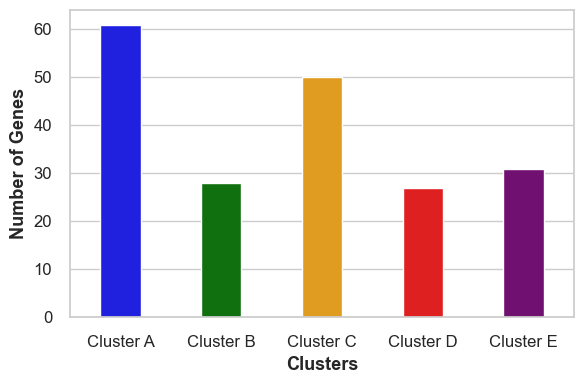

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a list of categories and corresponding colors
category_colors = {
    "Cluster A": "blue",
    "Cluster B": "green",
    "Cluster C": "orange",
    "Cluster D": "red",
    "Cluster E": "purple"
}

# Assuming you have a list of categories and corresponding values
categories = ["Cluster A", "Cluster B", "Cluster C", "Cluster D", "Cluster E"]
values = [61, 28, 50, 27, 31]

# Create Seaborn style bar plot
sns.set(style="whitegrid")

# Specify the bar width
bar_width = 0.4

# Create the bar plot and set the palette based on category_colors
plt.figure(figsize=(6, 4))
sns.barplot(x=categories, y=values, palette=[category_colors[cat] for cat in categories], ci=None, capsize=0.2, width=bar_width)

# Set the font weight for the x and y axis labels
plt.rc('axes', labelweight='bold')

# Set the labels for x and y axes
plt.xlabel("Clusters", fontsize=13)
plt.ylabel("Number of Genes",  fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("/Users/zhangchenyang/Desktop/old_3_numbers.pdf", format="pdf")

# Show the plot
plt.show()


Extraction of the first principal component for each type of gene

In [10]:
from sklearn.decomposition import PCA

cluster_class_data  = pd.DataFrame()
for m in range(5):
    class_m = cluster_data[cluster_data['label'] == m]
    class_m = class_m.iloc[:,:-1].T
    # first principal component
    pca = PCA(n_components=1)
    cluster_class_data = pd.concat([cluster_class_data, pd.DataFrame(pca.fit_transform(class_m)[:,0])], axis=1)


cluster_class_data.columns = ["ClusterA", "ClusterB", "ClusterC", "ClusterD", "ClusterE"]

cluster_class_data['fenzu_list'] = cluster_data.columns[:-1]
cluster_class_data= pd.merge(cluster_class_data, group, left_on='fenzu_list',right_on='BrainBank')

cluster_class_data.drop(['fenzu_list','BrainBank'],axis=1,inplace=True)
cluster_class_data

,ClusterA,ClusterB,ClusterC,ClusterD,ClusterE,CDR
0,-3.111681,8.764876,5.596656,-2.350770,-0.363778,CDR2
1,-0.813034,-5.195916,-4.019205,-4.144205,-4.262915,CDR0
2,0.865323,0.210081,1.682452,-2.040741,-1.716661,CDR0
3,-2.096346,2.254714,-2.652047,-1.834963,-3.403392,CDR2
4,-1.298082,3.806947,7.226237,-1.838427,4.148587,CDR2
...,...,...,...,...,...,...
80,-1.417393,3.551265,5.638964,0.170422,4.637248,CDR2
81,-1.109580,-3.229742,-1.362751,6.214908,8.651514,CDR1
82,-1.660555,5.174661,6.642004,0.935011,5.031258,CDR2
83,-0.853239,-3.747411,-2.924285,-4.831246,-4.590978,CDR0


Calculate the variance contribution of the first principal component

In [11]:
for m in range(5):
    class_m = cluster_data[cluster_data['label'] == m]
    class_m = class_m.iloc[:,:-1].T
    # first principal component
    pca = PCA()
    pca.fit_transform(class_m)
    first_principal_component_variance = pca.explained_variance_[0]  # Variance of the first principal component
    total_variance = np.sum(pca.explained_variance_)  # total variance
    contribution_ratio = first_principal_component_variance / total_variance
    print(contribution_ratio)

0.1699216032427904
0.5338668529769856
0.3711736837129753
0.521321272697422
0.5364056091241008


Plotting the bar chart of the variance contribution of the first principal component

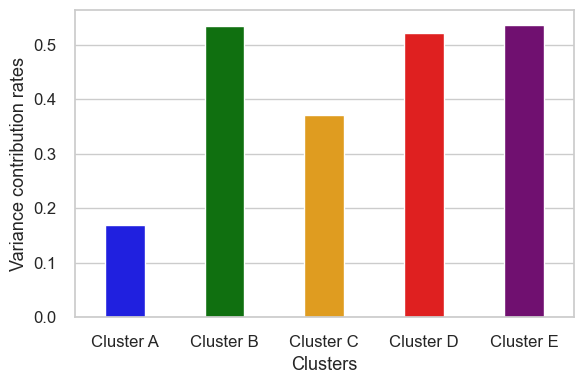

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a list of categories and corresponding colors
category_colors = {
    "Cluster A": "blue",
    "Cluster B": "green",
    "Cluster C": "orange",
    "Cluster D": "red",
    "Cluster E": "purple"
}

categories = ["Cluster A", "Cluster B", "Cluster C", "Cluster D", "Cluster E"]
values = [0.1699216032427904, 0.5338668529769856, 0.3711736837129753, 0.521321272697422, 0.5364056091241008]

# Create Seaborn style bar plot
sns.set(style="whitegrid")

# Specify the bar width
bar_width = 0.4

# Create the bar plot and set the palette based on category_colors
plt.figure(figsize=(6, 4))
sns.barplot(x=categories, y=values, palette=[category_colors[cat] for cat in categories], ci=None, capsize=0.2, width=bar_width)

# Set the font weight for the x and y axis labels
plt.rc('axes', labelweight='bold')

# Set the labels for x and y axes
plt.xlabel("Clusters", fontsize=13)
plt.ylabel("Variance contribution rates", fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("/Users/zhangchenyang/Desktop/old_3_contribution.pdf", format="pdf")

# Show the plot
plt.show()

Decision Tree Validation

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
import graphviz

from sklearn.utils import shuffle
cluster_class_data = shuffle(cluster_class_data, random_state=42)

Disrupt the order of the samples 20 times and calculate the average accuracy

In [14]:
e_m_l = []
e_m = []
e_l = []
m_l = []

for i in range(20):
    cluster_class_data = shuffle(cluster_class_data, random_state=i)

    # early, middle and late stage
    data1 = cluster_class_data.copy()
    CART_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2)
    temp1 = cross_val_score(CART_tree, data1.drop('CDR', axis=1),
                            data1['CDR'], cv=6,n_jobs=-1).mean()
    e_m_l.append(temp1)

    # early and middle stage
    data2 = cluster_class_data[cluster_class_data['CDR'] != 'CDR2']
    CART_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    temp2 = cross_val_score(CART_tree, data2.drop('CDR', axis=1),
                            data2['CDR'], cv=6,n_jobs=-1).mean()
    e_m.append(temp2)

    # early and late stage
    data3 = cluster_class_data[cluster_class_data['CDR'] != 'CDR1']
    CART_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    temp3 = cross_val_score(CART_tree, data3.drop('CDR', axis=1),
                            data3['CDR'], cv=6,n_jobs=-1).mean()
    e_l.append(temp3)

    # middle and late stage
    data4 = cluster_class_data[cluster_class_data['CDR'] != 'CDR0']
    CART_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    temp4 = cross_val_score(CART_tree, data4.drop('CDR', axis=1),
                            data4['CDR'], cv=6,n_jobs=-1).mean()
    m_l.append(temp4)

print('early, middle and late stage：', np.mean(e_m_l))
print('early and middle stage：', np.mean(e_m))
print('early and late stage：', np.mean(e_l))
print('middle and late stage：', np.mean(m_l))

早中晚： 0.8872619047619048
早中： 0.9040509259259257
早晚： 0.8804629629629632
中晚： 0.9241666666666667


 Disrupt the sample order 20 times and calculate the average feature importance

In [15]:
# View the classification features used for each cross-validation
from sklearn.model_selection import KFold

feature_importances_1 = []
feature_importances_2 = []
feature_importances_3 = []
feature_importances_4 = []

for i in range(20):
    cluster_class_data = shuffle(cluster_class_data, random_state=i)

    # early, middle and late stage---------------------------------------------------------------------------------
    data1 = cluster_class_data.copy()

    X = data1.drop('CDR', axis=1)
    y = data1['CDR']
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2)
    cv = KFold(n_splits=6,)

    for train_index, test_index in cv.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)

        importance = clf.feature_importances_
        feature_importances_1.append(list(importance))


    # early and middle stage---------------------------------------------------------------------------------
    data2 = cluster_class_data[cluster_class_data['CDR'] != 'CDR2']

    X = data2.drop('CDR', axis=1)
    y = data2['CDR']
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    cv = KFold(n_splits=6,)

    for train_index, test_index in cv.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)

        importance = clf.feature_importances_
        feature_importances_2.append(list(importance))


    # early and late stage---------------------------------------------------------------------------------
    data3 = cluster_class_data[cluster_class_data['CDR'] != 'CDR1']

    X = data3.drop('CDR', axis=1)
    y = data3['CDR']
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    cv = KFold(n_splits=6,)

    for train_index, test_index in cv.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)

        importance = clf.feature_importances_
        feature_importances_3.append(list(importance))


    # middle and late stage---------------------------------------------------------------------------------
    data4 = cluster_class_data[cluster_class_data['CDR'] != 'CDR0']

    X = data4.drop('CDR', axis=1)
    y = data4['CDR']
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)
    cv = KFold(n_splits=6,)

    for train_index, test_index in cv.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)

        importance = clf.feature_importances_
        feature_importances_4.append(list(importance))



# early, middle and late stage---------------------------------------------------------------------------------
sums = [0] * len(feature_importances_1[0])
for sublist in feature_importances_1:
    for i, value in enumerate(sublist):
        sums[i] += value
num_sublists = len(feature_importances_1)
averages = [total / num_sublists for total in sums]
print("early, middle and late stage：", averages)


# early and middle stage---------------------------------------------------------------------------------
sums = [0] * len(feature_importances_2[0])
for sublist in feature_importances_2:
    for i, value in enumerate(sublist):
        sums[i] += value
num_sublists = len(feature_importances_2)
averages = [total / num_sublists for total in sums]
print("early and middle stage：", averages)


# early and late stage---------------------------------------------------------------------------------
sums = [0] * len(feature_importances_3[0])
for sublist in feature_importances_3:
    for i, value in enumerate(sublist):
        sums[i] += value
num_sublists = len(feature_importances_3)
averages = [total / num_sublists for total in sums]
print("early and late stage：", averages)


# middle and late stage---------------------------------------------------------------------------------
sums = [0] * len(feature_importances_4[0])
for sublist in feature_importances_4:
    for i, value in enumerate(sublist):
        sums[i] += value
num_sublists = len(feature_importances_4)
averages = [total / num_sublists for total in sums]
print("middle and late stage：", averages)

早中晚期： [0.000428250824040126, 0.5420484534069573, 0.004446843553814331, 0.36449087765208804, 0.08858557456310004]
早中期： [0.0, 0.0, 0.0, 0.8083333333333333, 0.19166666666666668]
早晚期： [0.0, 0.49166666666666664, 0.475, 0.0, 0.03333333333333333]
中晚期： [0.0, 0.9666666666666667, 0.0, 0.03333333333333333, 0.0]


### Early, middle and late decision trees

In [16]:
dt_data_ = cluster_class_data.copy()

feature=dt_data_.columns.to_list()[:-1]
class_names = dt_data_['CDR'].unique()
class_names

array(['CDR1', 'CDR2', 'CDR0'], dtype=object)

In [19]:
CART_tree = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=2)

e_m_l = cross_val_score(CART_tree, dt_data_.drop('CDR', axis=1),
                        dt_data_['CDR'], cv=5,n_jobs=-1).mean()

e_m_l

0.8941176470588236

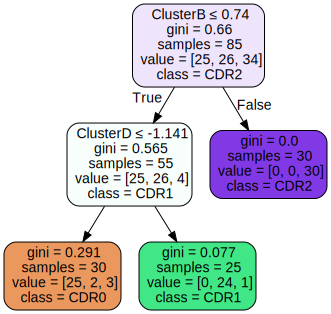

In [45]:
CART_tree = DecisionTreeClassifier(criterion='gini',splitter = 'best',max_depth=2)
CART_tree.fit(dt_data_.drop('CDR', axis=1), dt_data_['CDR'])
dot_data = tree.export_graphviz(CART_tree,
                                feature_names=feature,
                                class_names=[str(k) for k in np.unique(dt_data_['CDR'])],
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

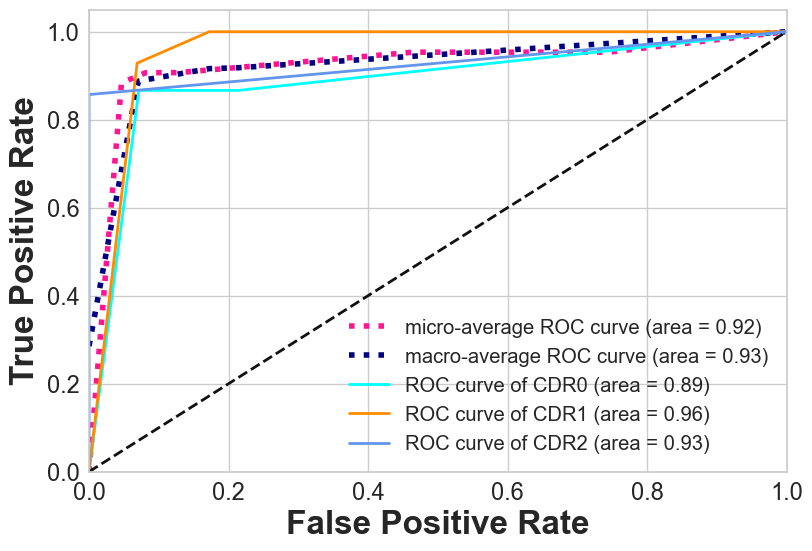

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

X = cluster_class_data.iloc[:, :4]
y = cluster_class_data.iloc[:, -1]

y = y.replace({'CDR0': 0, 'CDR1': 1, 'CDR2': 2})

y_binarized = label_binarize(y, classes=[0, 1, 2])
n_classes = y_binarized.shape[1]

random_state = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=.5, random_state=random_state)

tree_classifier = DecisionTreeClassifier(random_state=random_state, max_depth=2)

# build OneVsRestClassifier
classifier = OneVsRestClassifier(tree_classifier)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# calculate ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure(figsize=(9, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of CDR{0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", fontsize = 14.5, frameon=False)

plt.savefig("/Users/zhangchenyang/Desktop/old_3_早中晚ROC.pdf", format="pdf", bbox_inches = 'tight')
plt.show()

### Early and mid-term decision trees

In [44]:
dt_data_ = cluster_class_data[cluster_class_data['CDR'] != 'CDR2']

feature=dt_data_.columns.to_list()[:-1]
class_names = dt_data_['CDR'].unique()
class_names

array(['CDR1', 'CDR0'], dtype=object)

In [70]:
CART_tree = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=1)

e_m = cross_val_score(CART_tree, dt_data_.drop('CDR', axis=1),
                      dt_data_['CDR'], cv=5,n_jobs=-1).mean()
e_m

0.9236363636363636

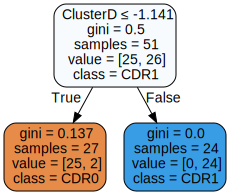

In [72]:
CART_tree = DecisionTreeClassifier(criterion='gini',splitter = 'best',max_depth=1)
CART_tree.fit(dt_data_.drop('CDR', axis=1), dt_data_['CDR'])
dot_data = tree.export_graphviz(CART_tree,
                                feature_names=feature,
                                class_names=[str(k) for k in np.unique(dt_data_['CDR'])],
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

<Figure size 800x550 with 0 Axes>

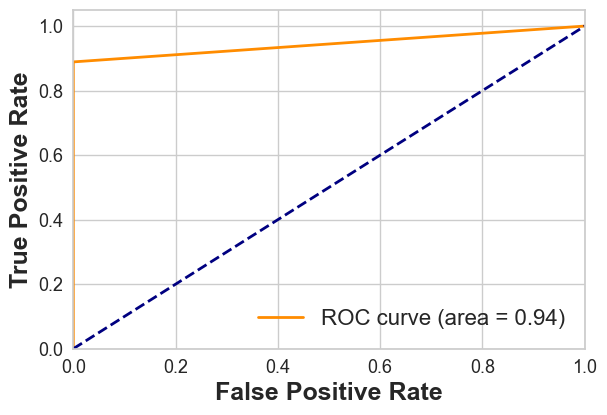

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

dt_data_ = cluster_class_data[cluster_class_data['CDR'] != 'CDR2']

X = dt_data_.iloc[:, :4]
y = dt_data_.iloc[:, -1]

y = y.replace({'CDR0': 0, 'CDR1': 1})

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(6.6, 4.4))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.legend(loc="lower right", frameon=False, fontsize = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig("/Users/zhangchenyang/Desktop/old_3_早中ROC.pdf", format="pdf", bbox_inches = 'tight')

plt.show()

### Early and Late Decision Trees

In [48]:
dt_data_ = cluster_class_data[cluster_class_data['CDR'] != 'CDR1']

feature=dt_data_.columns.to_list()[:-1]
class_names = dt_data_['CDR'].unique()
class_names

array(['CDR2', 'CDR0'], dtype=object)

In [305]:
CART_tree = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=1)

e_l = cross_val_score(CART_tree, dt_data_.drop('CDR', axis=1),
                      dt_data_['CDR'], cv=5,n_jobs=-1).mean()
e_l

0.9136363636363637

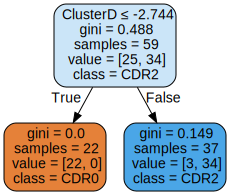

In [307]:
CART_tree = DecisionTreeClassifier(criterion='gini',splitter = 'best',max_depth=1)
CART_tree.fit(dt_data_.drop('CDR', axis=1), dt_data_['CDR'])
dot_data = tree.export_graphviz(CART_tree,
                                feature_names=feature,
                                class_names=[str(k) for k in np.unique(dt_data_['CDR'])],
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

<Figure size 800x550 with 0 Axes>

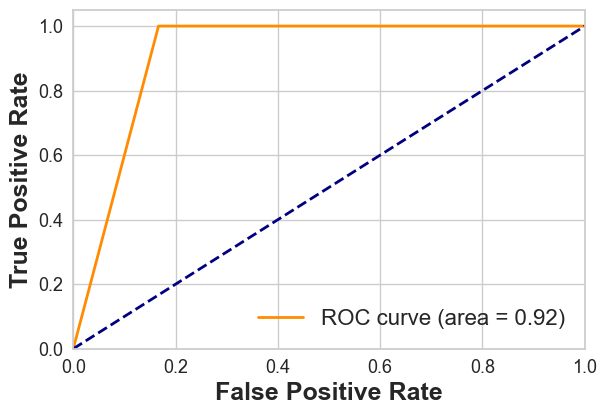

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

dt_data_ = cluster_class_data[cluster_class_data['CDR'] != 'CDR1']

X = dt_data_.iloc[:, :4]
y = dt_data_.iloc[:, -1]

y = y.replace({'CDR0': 0, 'CDR2': 1})

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(6.6, 4.4))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.legend(loc="lower right", frameon=False, fontsize = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig("/Users/zhangchenyang/Desktop/old_3_早晚ROC.pdf", format="pdf", bbox_inches = 'tight')

plt.show()

### Middle and Late Decision Trees

In [50]:
dt_data_ = cluster_class_data[cluster_class_data['CDR'] != 'CDR0']

feature=dt_data_.columns.to_list()[:-1]
class_names = dt_data_['CDR'].unique()
class_names

array(['CDR1', 'CDR2'], dtype=object)

In [278]:
CART_tree = DecisionTreeClassifier(
    criterion='gini', splitter='best', max_depth=1)

m_l = cross_val_score(CART_tree, dt_data_.drop('CDR', axis=1),
                      dt_data_['CDR'], cv=5,n_jobs=-1).mean()
m_l

0.9333333333333332

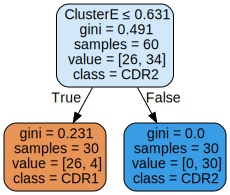

In [280]:
CART_tree = DecisionTreeClassifier(criterion='gini',splitter = 'best',max_depth=1)
CART_tree.fit(dt_data_.drop('CDR', axis=1), dt_data_['CDR'])
dot_data = tree.export_graphviz(CART_tree,
                                feature_names=feature,
                                class_names=[str(k) for k in np.unique(dt_data_['CDR'])],
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

<Figure size 800x550 with 0 Axes>

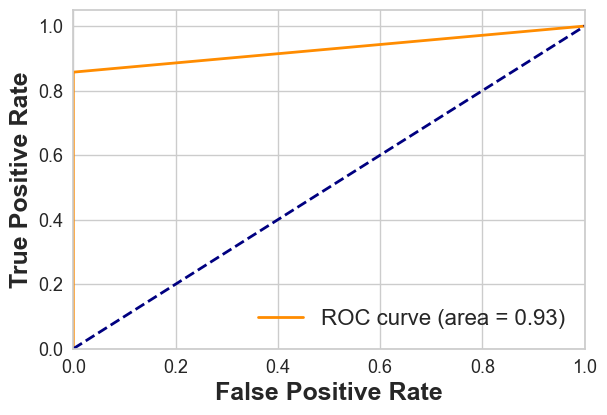

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

dt_data_ = cluster_class_data[cluster_class_data['CDR'] != 'CDR0']

X = dt_data_.iloc[:, :4]
y = dt_data_.iloc[:, -1]

y = y.replace({'CDR1': 0, 'CDR2': 1})

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(6.6, 4.4))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.legend(loc="lower right", frameon=False, fontsize = 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig("/Users/zhangchenyang/Desktop/old_3_中晚ROC.pdf", format="pdf", bbox_inches = 'tight')

plt.show()

In [281]:
print('e_m_l：', e_m_l)
print('e_m：', e_m)
print('e_l：', e_l)
print('m_l：', m_l)

早中晚： 0.8941176470588236
早中： 0.9
早晚： 0.8969696969696971
中晚： 0.9333333333333332
